# In this notebook
I implement a matching technique that leverages the Hamming Distance to match similar areas.

Key assumption:
* We assume images/temperatures are independent (which we know is not true), but for the sake of this assignment, this might be ok.

In [112]:
# Import all dependencies
import os
import numpy as np
from matplotlib import pyplot as plt

import torch
from multiprocessing import Pool
from torch.utils.data import Dataset
import time

# Load the images

In [113]:
file_path = '/datacommons/carlsonlab/zdc6/cs590/land_use/train'
imgs = os.listdir(os.path.join(file_path, 'img'))


class OneHotImages(Dataset):
    def __init__(self, file_path, files = None, transforms=None):
        self.file_path = file_path

        # Images
        if files is None:
            self.files = os.listdir(os.path.join(file_path, "img"))
        else:
            self.files = files
        
        # Define the number of processes to use
        self.num_processes = 8

    def __len__(self):
        return len(self.files)
    
    def _load_data(self, idx):
        img = torch.load(os.path.join(self.file_path, "img", self.files[idx]))

        with open(
            os.path.join(self.file_path, "labels", self.files[idx][:-3] + ".txt")
        ) as fp:
            label = float(fp.read())
        # Omit the tree class
        return img.numpy(), self.files[idx], label

    def __getitem__(self, idx):
        return self._load_data(idx)

    #Multiprocessing attempt
    def _load_data_parallel(self, indices):
        with Pool(self.num_processes) as p:
            data = p.map(self._load_data, indices)
        return data

    def get_data_parallel(self):
        indices = list(range(len(self)))
        return self._load_data_parallel(indices)

In [114]:
# We only need the training data
train = OneHotImages("/datacommons/carlsonlab/zdc6/cs590/land_use/train")

# Define the treatment and bin accordingly

In [115]:
# Multiprocessing attempt
# Overhead of managing processes longer than sequential approach
start = time.time()
train_data = train.get_data_parallel()
print(time.time() - start)

11.014486312866211


In [124]:
# Define the treatment distance in pixels, the class of interest, 
# and the percentage greater than for the treatment, and percentage less than
# for the control

def create_treatment_and_control_groups(distance, treatment, control, treatment_pctg, control_pctg):
    # Add files to this list for matching
    start = time.time()
    
    treatment_group = []
    control_group = []
    
    # Set a few variables
    w, h, _ = train[0][0].shape

    # Look at each image and file into the categories
    for img, file_name, label in train_data: 
        # Look at pixels in the middle of the image
        area = img[w//2 - distance:w//2 + distance, h//2 - distance:h//2 + distance, :]

        if area[:, :, treatment].mean() > treatment_pctg:
            treatment_group.append((img, file_name, label))

        if area[:, :, control].mean() > control_pctg:
            control_group.append((img, file_name, label))
    
    print(f"{time.time() - start} seconds")
    
    return treatment_group, control_group

In [125]:
distance = 10
treatment = 0   # 0 is roughly concrete, 1 is grass, 2 is trees, 3 is building? this isn't exact
control = 2
treatment_pctg = 0.9
control_pctg = 0.9

In [126]:
treatment, control = create_treatment_and_control_groups(distance, treatment, control, treatment_pctg, control_pctg)

0.031026363372802734 seconds


In [119]:
# Let's summarize our data
print(f"The treatment group has {len(treatment)} images.")
print(f"The control group has {len(control)} images.")

The treatment group has 11 images.
The control group has 82 images.


In [120]:
# Create image datasets for reading
#treatment = OneHotImages("/datacommons/carlsonlab/zdc6/cs590/land_use/train", files = treatment_group)
#control = OneHotImages("/datacommons/carlsonlab/zdc6/cs590/land_use/train", files = control_group)

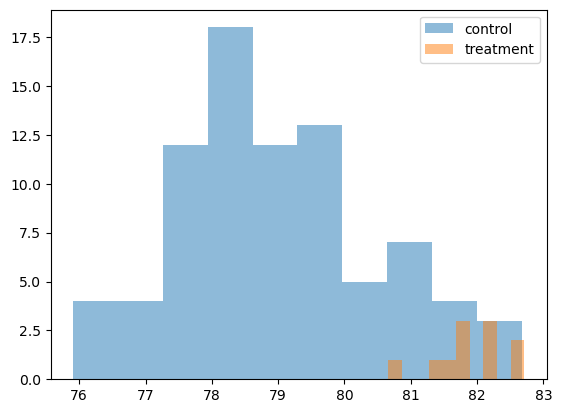

In [121]:
# Do an initial comparison of the images
treatment_temps = []
for img, file_name, label in treatment:
    treatment_temps.append(label)
    
control_temps = []
for img, file_name, label in control:
    control_temps.append(label)
    
plt.hist(control_temps, label='control', alpha=0.5)
plt.hist(treatment_temps, label='treatment', alpha=0.5)
plt.legend()
plt.show()

# Perform matching

In [123]:
#from sklearn.metrics import hamming_loss
from scipy.spatial.distance import hamming as hamming_loss

start = time.time()
treatment_temps = []
control_temps = []

for t_img, _, t_temp in treatment:
    best_hamming = 1
    best_temp = 0
    for c_img, _, c_temp in control:
        # Calculate the hamming distance.
        sim = hamming_loss(t_img.flatten(), c_img.flatten())
        if sim < best_hamming:
            best_hamming = sim
            best_temp = c_temp
    print(best_hamming)
    treatment_temps.append(t_temp)
    control_temps.append(best_temp)

print(f"{time.time() - start} seconds")

0.3084564208984375
0.27655029296875
0.2482757568359375
0.2613067626953125
0.2688751220703125
0.282806396484375
0.27613067626953125
0.24207305908203125
0.27639007568359375
0.25765228271484375
0.28502655029296875
0.7050459384918213 seconds


So, at the given tolerances, the best we can do is about 0.26 for Hamming distances. TBH this hamming distance doesn't seem that bad? This means that 3/4 of the labels agree. Still, this is not going to be as accurate, because it assumes that the noise in agreement is independent, which is almost surely not the case.

# Calculate the expected temperature impact

In [87]:
def average_treatment_effect(treatment_temps, control_temps):
    return np.mean(treatment_temps) - np.mean(control_temps)

In [88]:
ate = average_treatment_effect(treatment_temps, control_temps)
print(f"The average treatment effect is {ate:.1f} degrees F.")

The average treatment effect is 3.7 degrees F.
